# Sistema de IA para triaje de pacientes con tendinopatía calcificada del manguito rotador, susceptible para lavado percutáneo guiado por ecografía

### Hospital Universitario Rey Juan Carlos - Diagnóstico por imagen	


#### Javier Álvarez Benito y Javier Pozo Ocampo

In [11]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.layers.experimental.preprocessing as preprocessing


## Cargamos BBDD

In [12]:
data = pd.read_excel('calcific_tendinopathy_ddbb.xlsx')

In [13]:
data.head(30)

,image,calcium,pat_id,type,localization
0,0072879_001.png,1,72879,2,supraespinoso
1,0072879_002.png,1,72879,2,supraespinoso
2,00326955M_001.png,1,326955M,3,supraespinoso
3,00326955M_002.png,1,326955M,3,supraespinoso
4,0094847_001.png,0,94847,-1,NaN
5,00486523M_001.png,1,486523M,2,infraespinoso
6,00486523M_002.png,1,486523M,2,infraespinoso
7,00564810_001.png,1,564810,1,supraespinoso
8,00564810_002.png,1,564810,1,supraespinoso
9,00782404_001.png,1,782404,1,supraespinoso


## Cargamos las imagenes en train y validation

In [14]:
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    './train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    './valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

Found 14 files belonging to 2 classes.
Found 13 files belonging to 2 classes.


In [15]:
# Data Pipeline
def convert_to_float(image, label):
    image = tensorflow.image.convert_image_dtype(image, dtype=tensorflow.float32)
    return image, label

AUTOTUNE = tensorflow.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


## Data Augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


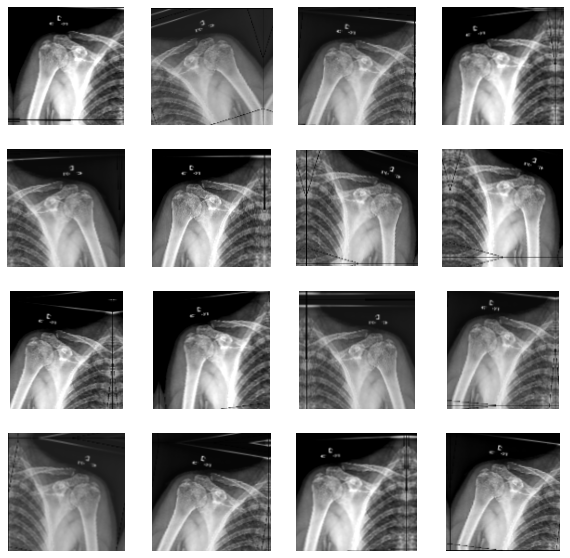

In [24]:
#Comprobacion de distintos tipos de augmentation para ver cual nos puede interesar mas

augment = tensorflow.keras.Sequential([
    preprocessing.RandomContrast(factor=0.3),
    preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
    #preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
    preprocessing.RandomWidth(factor=0.05), # horizontal stretch
    preprocessing.RandomRotation(factor=0.05),
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
])


ex = next(iter(ds_train.unbatch().map(lambda x, y: x).batch(1)))

plt.figure(figsize=(10,10))
for i in range(16):
    image = augment(ex, training=True)
    plt.subplot(4, 4, i+1)
    plt.imshow(tensorflow.squeeze(image))
    plt.axis('off')
plt.show()

## Dibujar las imagenes

In [17]:
def dibujar_imagen_calcio(image):
    img = io.imread(image,as_gray=True)
    img = img/np.max(img)
    plt.figure(figsize=(10,10)) 
    plt.imshow(img, cmap=plt.cm.gray)
    plt.title('Imagen con calcio',fontsize = 20),plt.axis('off')
    return img

In [18]:
dibujar_imagen_calcio(data.image[0])    

FileNotFoundError: No such file: '/media/obarquero/Almacenamiento/github/HURJC/0072879_001.png'

In [19]:
dibujar_imagen_calcio(data.image[1])

FileNotFoundError: No such file: '/media/obarquero/Almacenamiento/github/HURJC/0072879_002.png'

In [7]:
def dibujar_imagen_nocalcio(image):
    img = io.imread(image,as_gray=True)
    img = img/np.max(img)
    
    plt.figure(figsize=(10,10))         
    plt.imshow(img, cmap=plt.cm.gray)               
    plt.title('Imagen sin calcio',fontsize = 20),plt.axis('off')
    
    return img

array([[0.0627451 , 0.04176118, 0.04176118, ..., 0.01122196, 0.        ,
        0.01122196],
       [0.0627451 , 0.0627451 , 0.04176118, ..., 0.01122196, 0.        ,
        0.01122196],
       [0.0627451 , 0.0627451 , 0.04176118, ..., 0.01122196, 0.        ,
        0.01122196],
       ...,
       [0.8630051 , 0.76496588, 0.76496588, ..., 0.01122196, 0.01122196,
        0.03137255],
       [0.89437765, 0.80784314, 0.84202118, ..., 0.01122196, 0.01122196,
        0.03137255],
       [0.90476627, 0.8630051 , 0.84202118, ..., 0.01122196, 0.01122196,
        0.01122196]])

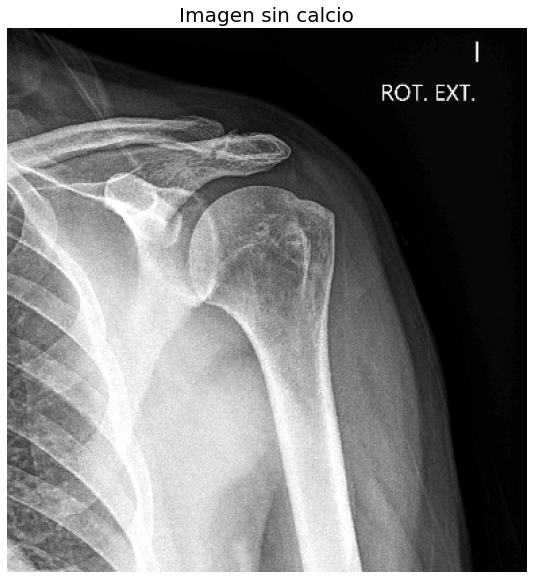

In [8]:
dibujar_imagen_nocalcio(data.image[4])

array([[0.01122196, 0.01122196, 0.01122196, ..., 0.1369949 , 0.1369949 ,
        0.1369949 ],
       [0.01122196, 0.01122196, 0.01122196, ..., 0.15797882, 0.15797882,
        0.15797882],
       [0.01122196, 0.01122196, 0.01122196, ..., 0.1369949 , 0.15797882,
        0.1369949 ],
       ...,
       [0.07313373, 0.0627451 , 0.09523373, ..., 0.55463059, 0.58600314,
        0.57478118],
       [0.07313373, 0.07313373, 0.10562235, ..., 0.61737569, 0.58600314,
        0.60615373],
       [0.07313373, 0.10562235, 0.12660627, ..., 0.61737569, 0.60615373,
        0.58600314]])

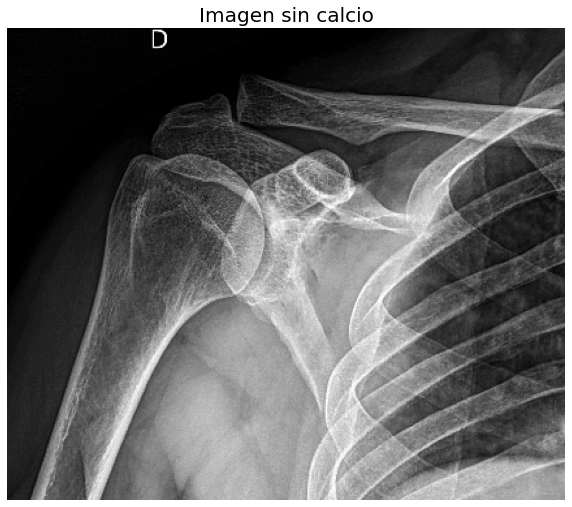

In [9]:
dibujar_imagen_nocalcio(data.image[19])

## Diseñamos la CNN

In [129]:
model = tensorflow.keras.Sequential([
    layers.InputLayer(input_shape=[128, 128,3]),
    # Data Augmentation
    preprocessing.RandomContrast(factor=0.5),
    preprocessing.RandomFlip(mode='horizontal'),
    preprocessing.RandomRotation(factor=0.20),
    
    # Block One
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two

    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

In [130]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_contrast_3 (RandomCon (None, 128, 128, 3)       0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 128, 128, 3)       0         
_________________________________________________________________
random_rotation_4 (RandomRot (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 32, 32, 128)     

In [131]:
model.compile(
    optimizer=tensorflow.keras.optimizers.Adam(epsilon=0.01),
    loss = 'binary_crossentropy',
    metrics = ['binary_accuracy']
)

In [132]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=20,
)

Epoch 1/20
1/1 [==============================] - 0s 396ms/step - loss: 0.6843 - binary_accuracy: 0.7143 - val_loss: 0.6877 - val_binary_accuracy: 0.6154
Epoch 2/20
1/1 [==============================] - 0s 240ms/step - loss: 0.6746 - binary_accuracy: 0.7143 - val_loss: 0.6831 - val_binary_accuracy: 0.6154
Epoch 3/20
1/1 [==============================] - 0s 488ms/step - loss: 0.6658 - binary_accuracy: 0.7143 - val_loss: 0.6803 - val_binary_accuracy: 0.6154
Epoch 4/20
1/1 [==============================] - 0s 340ms/step - loss: 0.6488 - binary_accuracy: 0.7143 - val_loss: 0.6803 - val_binary_accuracy: 0.6154
Epoch 5/20
1/1 [==============================] - 0s 378ms/step - loss: 0.6414 - binary_accuracy: 0.7143 - val_loss: 0.6835 - val_binary_accuracy: 0.6154
Epoch 6/20
1/1 [==============================] - 0s 322ms/step - loss: 0.6351 - binary_accuracy: 0.7143 - val_loss: 0.6905 - val_binary_accuracy: 0.6154
Epoch 7/20
1/1 [==============================] - 0s 256ms/step - loss: 0.64

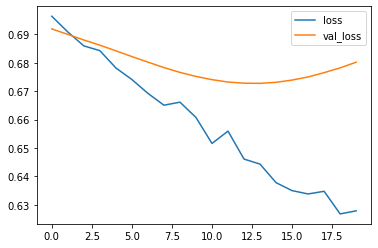

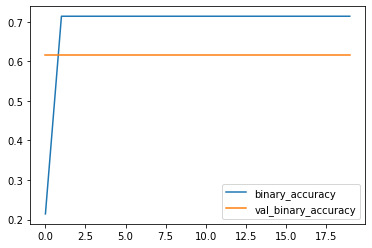

In [128]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();